## Mendez Medical Center
## Part 1: NYU ED Algorithm Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.proportion as smp

In [2]:

# Set background style
sns.set_style("whitegrid")

# Load raw data
df = pd.read_csv('ER_Inpatient_Dx_Info.csv')

# Inspect column names and first few rows
print("Columns in CSV:", df.columns.tolist())
pd.set_option('display.max_columns', None)

# Drop PII & non‐feature columns
drop_cols = [
    'MEMBNO', 'COVERED_DAYS', 'HICN',
    'PCPID', 'NPI', 'PCPNAME', 'MEMBNAME',
    'PRVORG', 'PRVORGNAME', 'HCCC',
    'SPECNPI', 'SPECTAXID', 'SERVQTY',
    'CLAIM_ID', 'SRC_CLM_ID', 'SOURCEVENDOR_ID',
    'PARCODE', 'GROUP', 'BENPKG', 'SNPFLAG',
    'PLANID', 'COUNTY', 'RELATION',
    'SPECID', 'SPECCODE', 'SPECIALTY',
    'PROC_CD', 'MODIFIER_CD', 'FFS_CAP',
    'PROCEDURE 2', 'ESRD'
]
df_clean = df.drop(columns=drop_cols, errors='ignore')

# Verify remaining columns
print(f"Remaining columns ({df_clean.shape[1]}): {df_clean.columns.tolist()}")

# Save cleaned data for downstream use
df_clean.to_csv('cleaned_avoid_er.csv', index=False)


Columns in CSV: ['PLANID', 'COUNTY', 'PCPID', 'NPI', 'PCPNAME', 'PRVORG', 'PRVORGNAME', 'MEMBNO', 'MEMBNAME', 'GROUP', 'BENPKG', 'DOB', 'AGE', 'GENDER', 'RELATION', 'SPECID', 'SPECNPI', 'SPECTAXID', 'SPECNAME', 'SPECCODE', 'SPECIALTY', 'CLAIM_ID', 'SRC_CLM_ID', 'DOS', 'PROC_CD', 'MODIFIER_CD', 'MCC', 'FFS_CAP', 'COVERED_DAYS', 'DX1_CD', 'DIAGNOSIS_DESCRP', 'HCCC', 'SERVQTY', 'PARCODE', 'PROCEDURE 2', 'SOURCEVENDOR_ID', 'ESRD', 'SNPFLAG', 'HICN', 'DIAGNOSIS 01', 'DIAGNOSIS 02', 'DIAGNOSIS 03', 'DIAGNOSIS 04', 'DIAGNOSIS 05', 'DIAGNOSIS 06']
Remaining columns (14): ['DOB', 'AGE', 'GENDER', 'SPECNAME', 'DOS', 'MCC', 'DX1_CD', 'DIAGNOSIS_DESCRP', 'DIAGNOSIS 01', 'DIAGNOSIS 02', 'DIAGNOSIS 03', 'DIAGNOSIS 04', 'DIAGNOSIS 05', 'DIAGNOSIS 06']


In [ ]:
# Reload df_clean from previous code block
df_ed = df_clean.copy()
print(f"Total visits in dataset: {len(df_ed):,}")

# Keep only true ED visits
df_ed = df_ed[df_ed['MCC'].str.upper().str.strip() == 'EMERGENCY ROOM'].copy()
print(f"ED‐only visits after filter: {len(df_ed):,}\n")

# Load the NYU ED ICD-10 mapping
nyu = pd.read_csv('2017_icd10_hesr.csv')
print("NYU mapping columns:", nyu.columns.tolist())

# Helper function to standardize ICD-10 codes
def clean_icd(col: pd.Series) -> pd.Series:
    return col.str.upper().str.replace('.', '', regex=False).str.strip()

# Standardize codes in both DataFrames
df_ed['DX_std'] = clean_icd(df_ed['DX1_CD'])
nyu['dx_std']   = clean_icd(nyu['dx'])

# Compute the avoidable-use probability
nyu['P_avoidable'] = nyu['noner'] + nyu['epct'] + nyu['edcnpa']

# Exact merge on full code
df_ed = df_ed.merge(
    nyu[['dx_std', 'P_avoidable']],
    how='left',
    left_on='DX_std',
    right_on='dx_std'
)

# Fallback: match on first 5 characters for any remaining NaNs
if df_ed['P_avoidable'].isna().any():
    df_ed['DX_pref5'] = df_ed['DX_std'].str[:5]
    nyu['dx_pref5']   = nyu['dx_std'].str[:5]

    df_ed = df_ed.merge(
        nyu[['dx_pref5', 'P_avoidable']].rename(columns={'P_avoidable':'P_fb'}),
        how='left',
        left_on='DX_pref5',
        right_on='dx_pref5'
    )
    df_ed['P_avoidable'] = df_ed['P_avoidable'].fillna(df_ed['P_fb'])
    df_ed.drop(columns=['dx_pref5', 'DX_pref5', 'P_fb'], inplace=True)

# Clean up helper columns
df_ed.drop(columns=['DX_std', 'dx_std'], inplace=True)

# Flag visits as avoidable (1), non-avoidable (0), or leave unmapped as NaN
threshold = 0.5
df_ed['avoidable_flag'] = df_ed['P_avoidable'].apply(
    lambda p: np.nan if pd.isna(p) else (1 if p >= threshold else 0)
)

# Diagnostics
missing_pct = df_ed['P_avoidable'].isna().mean() * 100
print(f"{missing_pct:.1f}% of ED visits remain unmapped after fallback")

dist = df_ed['avoidable_flag'].value_counts(dropna=False, normalize=True)
print("Avoidable_flag distribution (including NaNs):")
print(dist)

print("\nSample flagged visits:")
print(df_ed[['DX1_CD','P_avoidable','avoidable_flag']].head(8))

# Extract all unmapped ICD-10 codes for manual physician review
unmapped_codes = (
    df_ed[df_ed['P_avoidable'].isna()]['DX1_CD']
      .value_counts()
      .rename_axis('DX1_CD')
      .reset_index(name='count')
)

print(f"\nFound {len(unmapped_codes)} unique unmapped ICD-10 codes.")
print("Top 20 unmapped codes by frequency:")
print(unmapped_codes.head(20))

# Save this list so physician can assign avoidable probabilities
unmapped_codes.to_csv('nyu_unmapped_for_manual_review.csv', index=False)
print("Saved → nyu_unmapped_for_manual_review.csv")

Total visits in dataset: 11,254
ED‐only visits after filter: 7,639

NYU mapping columns: ['dx', 'dxname', 'dxshort', 'edcnnpa', 'edcnpa', 'epct', 'noner', 'alcohol', 'drug', 'injury', 'psych', 'unc']
11.4% of ED visits remain unmapped after fallback
Avoidable_flag distribution (including NaNs):
avoidable_flag
0.0    0.552219
1.0    0.333311
NaN    0.114469
Name: proportion, dtype: float64

Sample flagged visits:
     DX1_CD  P_avoidable  avoidable_flag
0  S70.01XA          0.0             0.0
1  S70.01XA          0.0             0.0
2  S70.01XA          0.0             0.0
3  S70.01XA          0.0             0.0
4  S70.01XA          0.0             0.0
5  S70.01XA          0.0             0.0
6  S70.01XA          0.0             0.0
7  S70.01XA          0.0             0.0

Found 111 unique unmapped ICD-10 codes.
Top 20 unmapped codes by frequency:
     DX1_CD  count
0     I16.0    226
1   G40.909    153
2     R51.9    140
3     U07.1    121
4     N17.9     80
5     K83.8     74
6    

In [4]:
# Define threshold & helper, in case this cell runs standalone 
threshold = 0.5

def flag_avoidable(p):
    if pd.isna(p):
        return np.nan
    return 1 if p >= threshold else 0

# Load physician’s completed manual mappings
manual = pd.read_csv('nyu_unmapped_for_manual_review_completed.csv')
print(f"Loaded manual overrides: {len(manual)} rows")

# Merge manual probabilities back into df_ed, overriding wherever provided
df_ed = df_ed.merge(
    manual[['DX1_CD', 'Manual_Avoidable']], 
    on='DX1_CD', 
    how='left'
)

mask_phys = df_ed['Manual_Avoidable'].notna()
df_ed.loc[mask_phys, 'P_avoidable']    = df_ed.loc[mask_phys, 'Manual_Avoidable']
df_ed.loc[mask_phys, 'avoidable_flag'] = df_ed.loc[mask_phys, 'Manual_Avoidable'].apply(flag_avoidable)

df_ed.drop(columns=['Manual_Avoidable'], inplace=True)

# Final class‐balance diagnostics 
print("\n── Final Class Balance ──")
print(df_ed['avoidable_flag'].value_counts(dropna=False, normalize=True))

print("\n── Sample Rows After Manual Override ──")
print(df_ed[['DX1_CD', 'P_avoidable', 'avoidable_flag']].sample(10, random_state=42))

# Save the fully‐flagged ED dataset to disk 
df_ed.to_csv('df_ed_flagged_complete.csv', index=False)
print("\nSaved → df_ed_flagged_complete.csv")

Loaded manual overrides: 111 rows

── Final Class Balance ──
avoidable_flag
0.0    0.596670
1.0    0.402282
NaN    0.001049
Name: proportion, dtype: float64

── Sample Rows After Manual Override ──
         DX1_CD  P_avoidable  avoidable_flag
3669      J11.1      0.75000             1.0
10854   M47.812      0.93750             1.0
10107    E11.43      1.00000             1.0
3781   S22.069A      0.00000             0.0
15212  S80.212A      0.00000             0.0
13246  S91.302A      0.00000             0.0
8881    M25.562      0.90625             1.0
11525     N17.9      1.00000             1.0
1606    K91.872      0.00000             0.0
14732   I63.512      0.00000             0.0

Saved → df_ed_flagged_complete.csv


In [ ]:
# Check for missing values and display the normalized distribution of 'avoidable_flag'
print("P_avoidable NaNs:", df_ed['P_avoidable'].isna().sum())
print("avoidable_flag NaNs:", df_ed['avoidable_flag'].isna().sum())

print("\nFinal avoidable_flag distribution:")
print(df_ed['avoidable_flag'].value_counts(dropna=False, normalize=True))

P_avoidable NaNs: 16
avoidable_flag NaNs: 16

Final avoidable_flag distribution:
avoidable_flag
0.0    0.596670
1.0    0.402282
NaN    0.001049
Name: proportion, dtype: float64


In [6]:
# Create a mask of rows still unmapped
mask_fallback = df_ed['avoidable_flag'].isna()

# Set both P_avoidable → 0 and avoidable_flag → 0
df_ed.loc[mask_fallback, 'P_avoidable']    = 0.0
df_ed.loc[mask_fallback, 'avoidable_flag'] = 0

# Confirm there are now zero NaNs
print("After default→0 → P_avoidable NaNs:",    df_ed['P_avoidable'].isna().sum())
print("After default→0 → avoidable_flag NaNs:", df_ed['avoidable_flag'].isna().sum())

# Review the new class balance
print("\nFinal avoidable_flag distribution (post-fallback):")
print(df_ed['avoidable_flag'].value_counts(normalize=True))

# Save your fully-labeled file
df_ed.to_csv('df_ed_flagged_complete.csv', index=False)
print("\nSaved → df_ed_flagged_complete.csv")


After default→0 → P_avoidable NaNs: 0
After default→0 → avoidable_flag NaNs: 0

Final avoidable_flag distribution (post-fallback):
avoidable_flag
0.0    0.597718
1.0    0.402282
Name: proportion, dtype: float64

Saved → df_ed_flagged_complete.csv


In [7]:
# Suppose df_ed is your final DataFrame
n_total = len(df_ed)                    # total ED visits
n_avoidable = int(df_ed['avoidable_flag'].sum())  # number flagged avoidable

# Wilson interval
ci_low, ci_high = smp.proportion_confint(
    count=n_avoidable,
    nobs=n_total,
    alpha=0.05,            # 95% CI
    method='wilson'        
)

print(f"Avoidable rate: {n_avoidable}/{n_total} = {n_avoidable/n_total:.1%}")
print(f"95% Wilson CI: {ci_low:.1%} – {ci_high:.1%}")

Avoidable rate: 6136/15253 = 40.2%
95% Wilson CI: 39.5% – 41.0%


### Data Visualization & Insights 

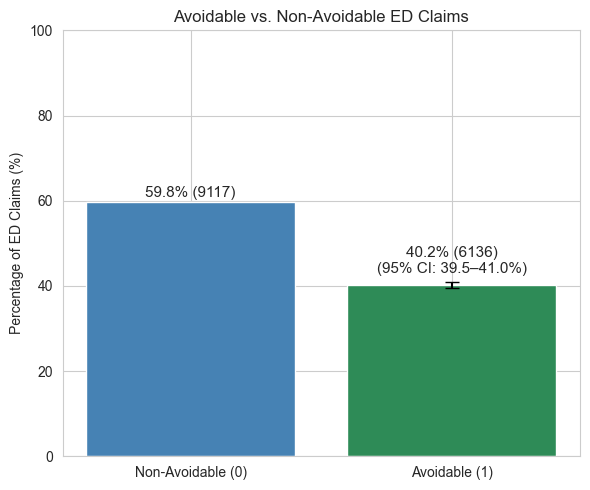

In [ ]:

# Compute counts & percentages
flag_counts = df_ed['avoidable_flag'].value_counts().sort_index()
flag_pct    = flag_counts / flag_counts.sum() * 100

# Compute 95% Wilson CI for avoidable rate
n_total     = int(flag_counts.sum())
n_avoidable = int(flag_counts.loc[1.0])
ci_low, ci_high = smp.proportion_confint(
    count=n_avoidable,
    nobs=n_total,
    alpha=0.05,
    method='wilson'
)

# Plot bar chart
plt.figure(figsize=(6, 5))
bars = plt.bar(
    ['Non-Avoidable (0)', 'Avoidable (1)'],
    flag_pct.values,
    color=['steelblue', 'seagreen']
)

plt.ylabel('Percentage of ED Claims (%)')
plt.title('Avoidable vs. Non-Avoidable ED Claims')

# Add error bar to the Avoidable bar
avoid_bar = bars[1]
y_val     = flag_pct.values[1]
err_down  = y_val - (ci_low * 100)
err_up    = (ci_high * 100) - y_val

plt.errorbar(
    x=avoid_bar.get_x() + avoid_bar.get_width()/2,
    y=y_val,
    yerr=[[err_down], [err_up]],
    fmt='none',
    ecolor='black',
    capsize=5
)

# Annotate Non‐Avoidable bar
bar0 = bars[0]
plt.text(
    bar0.get_x() + bar0.get_width()/2,
    bar0.get_height() + 1,
    f"{flag_pct.values[0]:.1f}% ({flag_counts.iloc[0]})",
    ha='center',
    fontsize=11
)

# Annotate Avoidable bar with two‐line label: percentage and CI
x_pos = avoid_bar.get_x() + avoid_bar.get_width()/2
plt.text(
    x_pos,
    y_val + err_up + 2,
    f"{y_val:.1f}% ({flag_counts.iloc[1]})\n(95% CI: {ci_low*100:.1f}–{ci_high*100:.1f}%)",
    ha='center',
    fontsize=11
)

# Final tweaks
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


C:\Users\Thiago\AppData\Local\Temp\ipykernel_46192\3806861943.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


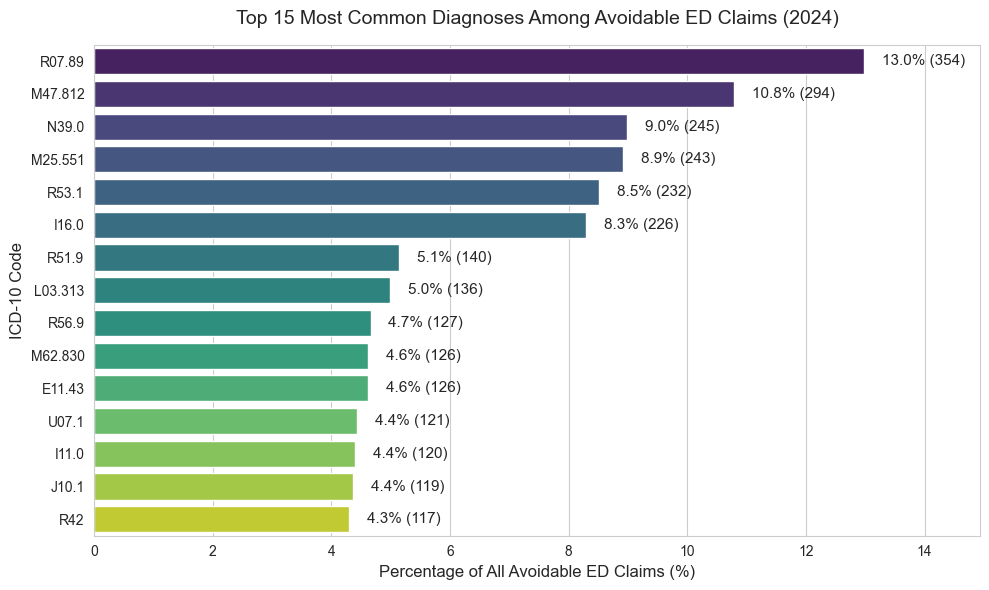

In [ ]:
# Function creates a horizontal bar plot showing the Top 15 ICD-10 codes
def plot_top_avoidable_codes(df, top_n=10):
    """
    Plot the top `top_n` avoidable diagnoses by percentage of all avoidable visits.
    """
    # Filter to only avoidable visits
    avoid_df = df[df['avoidable_flag'] == 1].copy()

    # Count occurrences of each ICD-10 code
    counts = avoid_df['DX1_CD'].value_counts().head(top_n)
    
    # Compute percentage of total avoidable visits
    pct = counts / counts.sum() * 100

    # Build DataFrame for plotting
    top_codes = pd.DataFrame({
        'DX1_CD': counts.index,
        'count': counts.values,
        'pct': pct.values
    })

    # Create horizontal barplot with viridis palette
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(
        x='pct',
        y='DX1_CD',
        data=top_codes,
        palette='viridis'
    )

    # Title and axis labels
    plt.title(f"Top {top_n} Most Common Diagnoses Among Avoidable ED Claims (2024)", fontsize=14, pad=15)
    plt.xlabel("Percentage of All Avoidable ED Claims (%)", fontsize=12)
    plt.ylabel("ICD-10 Code", fontsize=12)

    # Annotate each bar with its percentage
    for index, row in top_codes.iterrows():
        bar = barplot.patches[index]
        width = bar.get_width()
        y_pos = bar.get_y() + bar.get_height() / 2
        plt.text(
            x=width + 0.3,
            y=y_pos,
            s=f"{row['pct']:.1f}% ({row['count']})",
            va='center',
            fontsize=11
        )

    # Extend x-axis for annotations
    plt.xlim(0, top_codes['pct'].max() * 1.15)
    plt.tight_layout()
    plt.show()


# Load the final labeled dataset 
df_ed = pd.read_csv('df_ed_flagged_complete.csv')

# Plot the top 15 avoidable diagnoses 
plot_top_avoidable_codes(df_ed, top_n=15)


C:\Users\Thiago\AppData\Local\Temp\ipykernel_46192\656187852.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


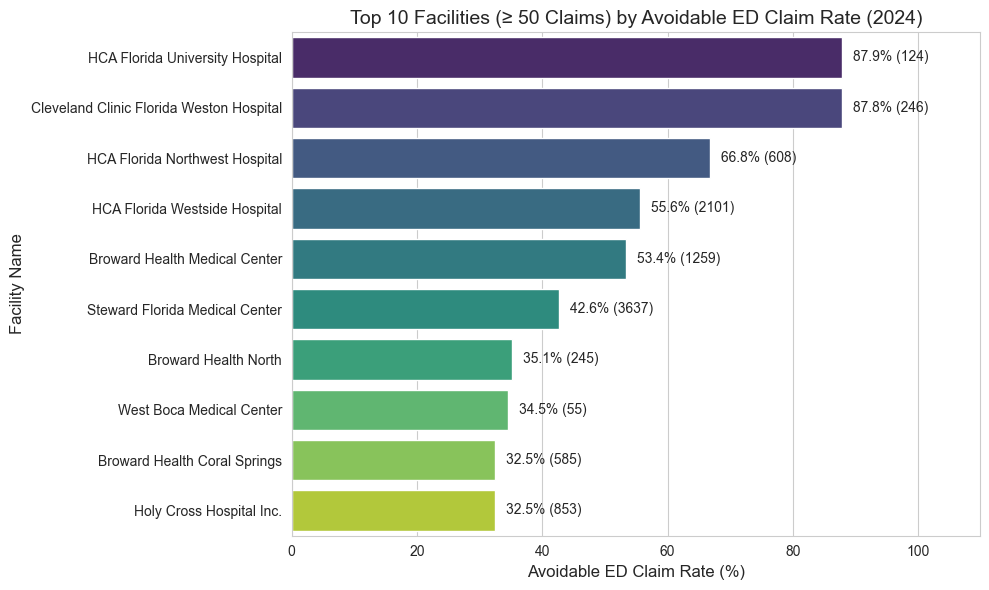

In [11]:
# Load and prepare the dataset
df_ed = pd.read_csv('df_ed_flagged_complete.csv')
df_ed['DOS'] = pd.to_datetime(df_ed['DOS'], errors='coerce')

# Restrict to calendar year 2024
year = 2024
start = pd.Timestamp(f'{year}-01-01')
end   = pd.Timestamp(f'{year + 1}-01-01')
df_year = df_ed[(df_ed['DOS'] >= start) & (df_ed['DOS'] < end)].copy()

# Compute facility‐level counts and rates
facility_summary = (
    df_year
      .groupby(['SPECNAME', 'avoidable_flag'])
      .size()
      .unstack(fill_value=0)
      .rename(columns={0: 'non_avoidable', 1: 'avoidable'})
)
facility_summary['total_visits'] = facility_summary['avoidable'] + facility_summary['non_avoidable']
facility_summary['avoidable_rate'] = (
    facility_summary['avoidable'] / facility_summary['total_visits'] * 100
)

# Filter to facilities with ≥ 50 total visits
min_visits = 50
filtered = facility_summary[facility_summary['total_visits'] >= min_visits].copy()

# Select top 10 by avoidable_rate
top10 = filtered.sort_values('avoidable_rate', ascending=False).head(10).copy()

# Prepare DataFrame for plotting
plot_df = top10.reset_index()[['SPECNAME', 'avoidable_rate', 'total_visits']]

# Plot with Seaborn using a “viridis” color gradient
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    x='avoidable_rate',
    y='SPECNAME',
    data=plot_df,
    palette='viridis'
)

plt.title(f"Top 10 Facilities (≥ {min_visits} Claims) by Avoidable ED Claim Rate ({year})", fontsize=14)
plt.xlabel("Avoidable ED Claim Rate (%)", fontsize=12)
plt.ylabel("Facility Name", fontsize=12)

# Annotate each bar with its percentage and total‐visit count, ensuring the text stays within the figure
max_rate = plot_df['avoidable_rate'].max()
plt.xlim(0, max_rate * 1.25)  # increase right boundary to make room for annotations

for idx, row in plot_df.iterrows():
    bar = barplot.patches[idx]
    width = bar.get_width()
    y_center = bar.get_y() + bar.get_height() / 2
    # Place annotation slightly inside if near the right edge
    x_pos = width + (max_rate * 0.02)
    plt.text(
        x=x_pos, 
        y=y_center, 
        s=f"{row['avoidable_rate']:.1f}% ({int(row['total_visits'])})", 
        va='center', 
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [ ]:
# Reload your fully‐flagged ED dataset 
df_ed = pd.read_csv('df_ed_flagged_complete.csv')

# Compute the Top 15 avoidable Dx codes (by count of flagged visits)
avoid_df = df_ed[df_ed['avoidable_flag'] == 1]
top15_codes = set(avoid_df['DX1_CD'].value_counts().head(15).index.tolist())

# Load the “completed” manual‐override file
manual = pd.read_csv('nyu_unmapped_for_manual_review_completed.csv')
manual_codes = set(manual['DX1_CD'].astype(str).tolist())

# Find any overlap between Top 15 and manual overrides
overlap = top15_codes.intersection(manual_codes)

print("Top 15 avoidable Dx codes:")
print(sorted(top15_codes), "\n")

print("Manually‐overridden codes:")
print(sorted(manual_codes), "\n")

print("Codes that appear in BOTH the Top 15 and the manual‐override list:")
print(sorted(overlap))

if not overlap:
    print("→ No Top 15 codes were manually overridden.")
else:
    print(f"→ {len(overlap)} code(s) were both in the Top 15 list and in your manual overrides.")


Top 15 avoidable Dx codes:
['E11.43', 'I11.0', 'I16.0', 'J06.9', 'J10.1', 'L03.313', 'M25.551', 'M47.812', 'M62.830', 'N39.0', 'R07.89', 'R51.9', 'R53.1', 'R56.9', 'U07.1'] 

Manually‐overridden codes:
['A41.51', 'A41.59', 'A41.89', 'B00.1', 'B34.8', 'B34.9', 'C15.9', 'C22.0', 'C67.9', 'C83.30', 'C92.00', 'D50.0', 'D50.9', 'D62', 'D69.0', 'E11.39', 'E11.52', 'E50.0', 'F10.139', 'F32.A', 'G35', 'G40.401', 'G40.419', 'G40.909', 'G50.0', 'G56.03', 'H33.022', 'H40.213', 'H43.12', 'H47.10', 'H74.8X2', 'H81.10', 'I13.0', 'I15.9', 'I16.0', 'I16.9', 'I44.0', 'I47.10', 'I47.20', 'I49.1', 'I49.5', 'I62.03', 'I65.21', 'I67.1', 'I71.02', 'I71.03', 'I95.1', 'I95.9', 'J15.7', 'K20.90', 'K20.91', 'K26.9', 'K31.89', 'K35.32', 'K40.30', 'K46.9', 'K55.9', 'K82.0', 'K83.8', 'K85.10', 'K85.90', 'K91.872', 'K94.23', 'L73.9', 'L76.32', 'L84', 'L97.514', 'L97.519', 'M11.261', 'M17.0', 'M19.012', 'M19.031', 'M19.072', 'M24.411', 'M46.1', 'M48.02', 'M48.061', 'M51.16', 'M51.17', 'M54.10', 'M54.50', 'M67.442', 